# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [40]:
import math
def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

In [41]:
d = 3
n = 4
sparsity = nCr(n+d, d)


x_max = 1#10 #this number excluded
x_min = -1#-10
x_step = 0.01#0.1
a_max = 10 #this number excluded
a_min = -10
a_step = 0.1

lambda_dataset_size = 1000 #specify the number of data points to train the lambda net on for loading (must be same as in previous notebook)

number_formulas_load = 1000 #manually specify number of formulas for loading file (must be the same as used in the previous notebook)
number_of_lambda_nets = number_formulas_load #use this parameter to select how many lambda nets should be generated (must be smaller or equal to number_formulas_load)


#lambda net specifications 
batch_size = 64
epochs = 200
lambda_network_layers = [5*sparsity]
dropout = 0.0
optimizer='SGD'

each_epochs_save = 10  #specifies the number of epochs to checkpoint lambda network weights, if None no checkpointing

same_training_all_lambda_nets = False

fixed_seed_lambda_training = False
fixed_initialization_lambda_training = True
number_different_lambda_trainings = 100

n_jobs = -3


In [42]:
##############DO NOT CHANGE###################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

RANDOM_SEED = 42

if each_epochs_save != None:
    epochs_save_range = range(1, epochs//each_epochs_save+1) if each_epochs_save == 1 else range(epochs//each_epochs_save+1)
else:
    epochs_save_range = None
    
layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])

advanced_metric_dataset_size = 10#200

if same_training_all_lambda_nets:
    training_string = '_same'
else:
    training_string = '_diverse'

generate_subset = True if number_of_lambda_nets < number_formulas_load else False

    
if generate_subset:
    data_size = number_of_lambda_nets
else:
    data_size = number_formulas_load

if fixed_seed_lambda_training:
    seed_shuffle_string = '_' + str(number_different_lambda_trainings) + '-FixedSeed'
else:
    seed_shuffle_string = '_NoFixedSeed'
    
if fixed_initialization_lambda_training:
    seed_shuffle_string += '_' + str(number_different_lambda_trainings) + '-FixedEvaluation'
else:
    seed_shuffle_string += '_NoFixedEvaluation'
    
    
use_gpu = False
if use_gpu:
    gpu_numbers = '0'
else:
    gpu_numbers = ''
    
structure = '_' + layers_str + str(epochs) + 'e' + str(batch_size) + 'b_' + optimizer 
    
filename = seed_shuffle_string + '_' + str(RANDOM_SEED) + structure

## Imports

In [43]:
import ttg
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil

import logging
logging.getLogger('tensorflow').disabled = True

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns
sns.set_style("darkgrid")
np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#keras.backend.set_epsilon(10e-3)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [44]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

In [45]:
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

def chunks(lst, chunksize):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), chunksize):
        yield lst[i:i + chunksize]

#test for exact equality
def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

def prod(iterable):
    return reduce(operator.mul, iterable, 1)


ALPHABET = \
  "0123456789abcdefghijklmnopqrstuvwxyz"

def encode (n):
    try:
        return ALPHABET [n]
    except IndexError:
        raise Exception ("cannot encode: %s" % n)
        
def dec_to_base (dec = 0, base = 16):
    if dec < base:
        return encode (dec)
    else:
        return dec_to_base (dec // base, base) + encode (dec % base)
    
    
def mergeDict(dict1, dict2):
    #Merge dictionaries and keep values of common keys in list
    newDict = {**dict1, **dict2}
    for key, value in newDict.items():
        if key in dict1 and key in dict2:
            if isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend(value)
            elif isinstance(dict1[key], list) and not isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend([value])
            elif not isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = [dict1[key]]
                newDict[key].extend(value)
            else:
                newDict[key] = [dict1[key], value]
    return newDict

## Loss/Error functions

In [46]:
def calcualate_function_value_with_X_data_entry(coefficient_list, X_data_entry):
    
    global list_of_monomial_identifiers
     
    result = 0    
    for coefficient_value, coefficient_multipliers in zip(coefficient_list, list_of_monomial_identifiers):
        partial_results = [X_data_value**int(coefficient_multiplier) for coefficient_multiplier, X_data_value in zip(coefficient_multipliers, X_data_entry)]
        
        result += coefficient_value * reduce(lambda x, y: x*y, partial_results)
        
    return result, np.append(X_data_entry, result)


In [47]:
def root_mean_squared_error(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    if tf.is_tensor(y_true):
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    else:
        y_true = tf.convert_to_tensor(y_true)
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    if tf.is_tensor(y_pred):
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
    else:
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
            
            
    return tf.math.sqrt(K.mean(K.square(y_pred - y_true))) 

def accuracy_multilabel(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    if 'float' in str(y_true[0].dtype):        
        if tf.is_tensor(y_true):
            y_true = tf.dtypes.cast(y_true, tf.float32) 
        else:
            y_true = y_true.astype('float32')
        if tf.is_tensor(y_pred):
            y_pred = tf.dtypes.cast(y_pred, tf.float32)
        else:
            y_pred = y_pred.astype('float32')
            
        n_digits = int(-np.log10(a_step))
        
        y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
        y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(tf.reduce_all(K.equal(y_true, y_pred), axis=1), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def accuracy_single(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    if 'float' in str(y_true[0].dtype):        
        if tf.is_tensor(y_true):
            y_true = tf.dtypes.cast(y_true, tf.float32) 
        else:
            y_true = y_true.astype('float32')
        if tf.is_tensor(y_pred):
            y_pred = tf.dtypes.cast(y_pred, tf.float32)
        else:
            y_pred = y_pred.astype('float32')
            
        n_digits = int(-np.log10(a_step))
        
        y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
        y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(K.equal(y_true, y_pred), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def mean_absolute_percentage_error_keras(y_true, y_pred, epsilon=10e-3): 
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values    
        
    if tf.is_tensor(y_true):
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    else:
        y_true = tf.convert_to_tensor(y_true)
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    if tf.is_tensor(y_pred):
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
    else:
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
        
    epsilon = tf.convert_to_tensor(epsilon)
    epsilon = tf.dtypes.cast(epsilon, tf.float32)
        
    return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + epsilon))))

def huber_loss_delta_set(y_true, y_pred):
    return keras.losses.huber_loss(y_true, y_pred, delta=0.3)

def relative_absolute_average_error(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
       
    #error value calculation    
    result = np.sum(np.abs(y_true-y_pred))/(y_true.shape[0]*np.std(y_true)) #correct STD?
    
    return result

def relative_maximum_average_error(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    #error value calculation    
    result = np.max(y_true-y_pred)/np.std(y_true) #correct STD?
    
    return result

### Generate List of Monomial Identifiers

In [48]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 256
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0013', '0020', '0021', '0022', '0023', '0030', '0031', '0032', '0033', '0100', '0101', '0102', '0103', '0110', '0111', '0112', '0113', '0120', '0121', '0122', '0123', '0130', '0131', '0132', '0133', '0200', '0201', '0202', '0203', '0210', '0211', '0212', '0213', '0220', '0221', '0222', '0223', '0230', '0231', '0232', '0233', '0300', '0301', '0302', '0303', '0310', '0311', '0312', '0313', '0320', '0321', '0322', '0323', '0330', '0331', '0332', '0333', '1000', '1001', '1002', '1003', '1010', '1011', '1012', '1013', '1020', '1021', '1022', '1023', '1030', '1031', '1032', '1033', '1100', '1101', '1102', '1103', '1110', '1111', '1112', '1113', '1120', '1121', '1122', '1123', '1130', '1131', '1132', '1133', '1200', '1201', '1202', '1203', '1210', '1211', '1212', '1213', '1220', '1221', '1222', '1223', '1230', '1231', '1232', '1233', '1


List length: 35
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0020', '0021', '0030', '0100', '0101', '0102', '0110', '0111', '0120', '0200', '0201', '0210', '0300', '1000', '1001', '1002', '1010', '1011', '1020', '1100', '1101', '1110', '1200', '2000', '2001', '2010', '2100', '3000']


## Load Data

In [49]:
path_polynomials = './data/saved_polynomial_lists/polynomials_sample' + str(number_formulas_load) + '_variables_' + str(n) +  '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step) + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '.csv'
polynomials_list_df = pd.read_csv(path_polynomials)

path_X_data = './data/saved_polynomial_lists/X_sample' + str(number_formulas_load) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) +  training_string + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_polynomial_lists/y_sample' + str(number_formulas_load) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) +  training_string + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if generate_subset:
    polynomials_list_df = polynomials_list_df.sample(n=number_of_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_lambda_nets)
    random.seed(RANDOM_SEED)

In [50]:
#clear files
if each_epochs_save != None:
    try:
        # Create target Directory
        os.mkdir('./data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename)
    except FileExistsError:
        
        for i in epochs_save_range:
            index = i*each_epochs_save if i > 1 else each_epochs_save if i==1 else 1
            path = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size)  + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(index).zfill(3)  + filename + '.txt'

            with open(path, 'wt') as text_file:
                text_file.truncate()   
    try:
        # Create target Directory
        os.mkdir('./data/results/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename)
    except FileExistsError:
        pass
else:
    
    try:
        # Create target Directory
        os.mkdir('./data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename)
    except FileExistsError:

        path = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

        with open(path, 'wt') as text_file:
            text_file.truncate()   
    try:
        # Create target Directory
        os.mkdir('./data/results/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename)
    except FileExistsError:
        pass
                

## Data Inspection

In [51]:
X_data_list[0][1].head()

,0,1,2,3
0,0.370,0.810,-0.660,-0.560
1,0.970,-1.000,-0.520,0.530
2,-0.560,-0.950,-0.190,0.250
3,0.750,-0.030,0.540,0.930
4,0.620,0.880,0.860,-0.520


In [52]:
X_data_list[1][1].head()

,0,1,2,3
0,-0.920,-0.440,-0.410,-1.000
1,0.650,-0.280,0.100,0.280
2,0.630,0.880,0.060,0.310
3,0.640,-0.170,-0.750,0.510
4,0.240,0.300,-0.700,-0.240


In [53]:
X_data_list[0][0].head()

0000    6.300
0001   -7.200
0002   -9.400
0003    8.900
0010   -3.000
Name: 0, dtype: float64

In [54]:
X_data_list[1][0].head()

0000   -9.900
0001    9.400
0002   -6.000
0003    7.800
0010    0.800
Name: 1, dtype: float64

## Lambda Network Training + Weigh/Bias saving

In [55]:
def evaluate_lambda_net(identifier, 
                        X_data_real_lambda, 
                        y_data_real_lambda, 
                        y_data_pred_lambda, 
                        y_data_pred_lambda_poly_lstsq, 
                        y_data_real_lambda_poly_lstsq):
    
    mae_real_VS_predLambda = np.round(mean_absolute_error(y_data_real_lambda, y_data_pred_lambda), 4)
    mae_real_VS_predPolyLstsq = np.round(mean_absolute_error(y_data_real_lambda, y_data_pred_lambda_poly_lstsq), 4)
    mae_predLambda_VS_predPolyLstsq = np.round(mean_absolute_error(y_data_pred_lambda_poly_lstsq, y_data_pred_lambda), 4)
    mae_real_VS_realPolyLstsq = np.round(mean_absolute_error(y_data_real_lambda, y_data_real_lambda_poly_lstsq), 4)    

    rmse_real_VS_predLambda = np.round(root_mean_squared_error(y_data_real_lambda, y_data_pred_lambda), 4)    
    rmse_real_VS_predPolyLstsq = np.round(root_mean_squared_error(y_data_real_lambda, y_data_pred_lambda_poly_lstsq), 4)    
    rmse_predLambda_VS_predPolyLstsq = np.round(root_mean_squared_error(y_data_pred_lambda_poly_lstsq, y_data_pred_lambda), 4)    
    rmse_real_VS_realPolyLstsq = np.round(root_mean_squared_error(y_data_real_lambda, y_data_real_lambda_poly_lstsq), 4)    

    mape_real_VS_predLambda = np.round(mean_absolute_percentage_error_keras(y_data_real_lambda, y_data_pred_lambda), 4)    
    mape_real_VS_predPolyLstsq = np.round(mean_absolute_percentage_error_keras(y_data_real_lambda, y_data_pred_lambda_poly_lstsq), 4)    
    mape_predLambda_VS_predPolyLstsq = np.round(mean_absolute_percentage_error_keras(y_data_pred_lambda_poly_lstsq, y_data_pred_lambda), 4)    
    mape_real_VS_realPolyLstsq = np.round(mean_absolute_percentage_error_keras(y_data_real_lambda, y_data_real_lambda_poly_lstsq), 4)            

    r2_real_VS_predLambda = np.round(r2_score(y_data_real_lambda, y_data_pred_lambda), 4)
    r2_real_VS_predPolyLstsq = np.round(r2_score(y_data_real_lambda, y_data_pred_lambda_poly_lstsq), 4)
    r2_predLambda_VS_predPolyLstsq = np.round(r2_score(y_data_pred_lambda_poly_lstsq, y_data_pred_lambda), 4)
    r2_real_VS_realPolyLstsq = np.round(r2_score(y_data_real_lambda, y_data_real_lambda_poly_lstsq), 4)

    raae_real_VS_predLambda = np.round(relative_absolute_average_error(y_data_real_lambda, y_data_pred_lambda), 4)
    raae_real_VS_predPolyLstsq = np.round(relative_absolute_average_error(y_data_real_lambda, y_data_pred_lambda_poly_lstsq), 4)
    raae_predLambda_VS_predPolyLstsq = np.round(relative_absolute_average_error(y_data_pred_lambda_poly_lstsq, y_data_pred_lambda), 4)
    raae_real_VS_realPolyLstsq = np.round(relative_absolute_average_error(y_data_real_lambda, y_data_real_lambda_poly_lstsq), 4)

    rmae_real_VS_predLambda = np.round(relative_maximum_average_error(y_data_real_lambda, y_data_pred_lambda), 4)
    rmae_real_VS_predPolyLstsq = np.round(relative_maximum_average_error(y_data_real_lambda, y_data_pred_lambda_poly_lstsq), 4)
    rmae_predLambda_VS_predPolyLstsq = np.round(relative_maximum_average_error(y_data_pred_lambda_poly_lstsq, y_data_pred_lambda), 4)
    rmae_real_VS_realPolyLstsq = np.round(relative_maximum_average_error(y_data_real_lambda, y_data_real_lambda_poly_lstsq), 4)
        
    std_data_real_lambda = np.round(np.std(y_data_real_lambda), 4) 
    std_data_pred_lambda = np.round(np.std(y_data_pred_lambda), 4) 
    std_data_pred_lambda_poly_lstsq = np.round(np.std(y_data_pred_lambda_poly_lstsq), 4) 
    std_data_real_lambda_poly_lstsq = np.round(np.std(y_data_real_lambda_poly_lstsq), 4) 

    mean_data_real_lambda = np.round(np.mean(y_data_real_lambda), 4) 
    mean_data_pred_lambda = np.round(np.mean(y_data_pred_lambda), 4) 
    mean_data_pred_lambda_poly_lstsq = np.round(np.mean(y_data_pred_lambda_poly_lstsq), 4) 
    mean_data_real_lambda_poly_lstsq = np.round(np.mean(y_data_real_lambda_poly_lstsq), 4) 

    return [{
             'MAE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA': mae_real_VS_predLambda,
             'MAE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA POLY LSTSQ': mae_real_VS_predPolyLstsq,
             'MAE FV ' + identifier + ' PRED LAMBDA VS PRED LAMBDA POLY LSTSQ': mae_predLambda_VS_predPolyLstsq,
             'MAE FV ' + identifier + ' REAL LAMBDA VS REAL LAMBDA POLY LSTSQ': mae_real_VS_realPolyLstsq,
             'RMSE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA': rmse_real_VS_predLambda,
             'RMSE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA POLY LSTSQ': rmse_real_VS_predPolyLstsq,
             'RMSE FV ' + identifier + ' PRED LAMBDA VS PRED LAMBDA POLY LSTSQ': rmse_predLambda_VS_predPolyLstsq,
             'RMSE FV ' + identifier + ' REAL LAMBDA VS REAL LAMBDA POLY LSTSQ': rmse_real_VS_realPolyLstsq,
             'MAPE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA': mape_real_VS_predLambda,
             'MAPE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA POLY LSTSQ': mape_real_VS_predPolyLstsq,
             'MAPE FV ' + identifier + ' PRED LAMBDA VS PRED LAMBDA POLY LSTSQ': mape_predLambda_VS_predPolyLstsq,
             'MAPE FV ' + identifier + ' REAL LAMBDA VS REAL LAMBDA POLY LSTSQ': mape_real_VS_realPolyLstsq,
             'R2 FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA': r2_real_VS_predLambda,
             'R2 FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA POLY LSTSQ': r2_real_VS_predPolyLstsq,
             'R2 FV ' + identifier + ' PRED LAMBDA VS PRED LAMBDA POLY LSTSQ': r2_predLambda_VS_predPolyLstsq,
             'R2 FV ' + identifier + ' REAL LAMBDA VS REAL LAMBDA POLY LSTSQ': r2_real_VS_realPolyLstsq,
             'RAAE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA': raae_real_VS_predLambda,
             'RAAE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA POLY LSTSQ': raae_real_VS_predPolyLstsq,
             'RAAE FV ' + identifier + ' PRED LAMBDA VS PRED LAMBDA POLY LSTSQ': raae_predLambda_VS_predPolyLstsq,
             'RAAE FV ' + identifier + ' REAL LAMBDA VS REAL LAMBDA POLY LSTSQ': raae_real_VS_realPolyLstsq,
             'RMAE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA': rmae_real_VS_predLambda,
             'RMAE FV ' + identifier + ' REAL LAMBDA VS PRED LAMBDA POLY LSTSQ': rmae_real_VS_predPolyLstsq,
             'RMAE FV ' + identifier + ' PRED LAMBDA VS PRED LAMBDA POLY LSTSQ': rmae_predLambda_VS_predPolyLstsq,
             'RMAE FV ' + identifier + ' REAL LAMBDA VS REAL LAMBDA POLY LSTSQ': rmae_real_VS_realPolyLstsq,
            },
            {
             'STD FV ' + identifier + ' REAL LAMBDA': std_data_real_lambda,
             'STD FV ' + identifier + ' PRED LAMBDA': std_data_pred_lambda, 
             'STD FV ' + identifier + ' PRED LAMBDA POLY LSTSQ': std_data_pred_lambda_poly_lstsq, 
             'STD FV ' + identifier + ' REAL LAMBDA POLY LSTSQ': std_data_real_lambda_poly_lstsq, 
            },
            {
             'MEAN FV ' + identifier + ' REAL LAMBDA': mean_data_real_lambda,
             'MEAN FV ' + identifier + ' PRED LAMBDA': mean_data_pred_lambda, 
             'MEAN FV ' + identifier + ' PRED LAMBDA POLY LSTSQ': mean_data_pred_lambda_poly_lstsq, 
             'MEAN FV ' + identifier + ' REAL LAMBDA POLY LSTSQ': mean_data_real_lambda_poly_lstsq, 
            }]
    
        

In [56]:
def calculate_function_values_from_polynomial(X_data, polynomial):
    function_value_list = []
    for entry in X_data:
        function_value, _ = calcualate_function_value_with_X_data_entry(polynomial, entry)
        function_value_list.append(function_value)
    function_value_array = np.array(function_value_list).reshape(len(function_value_list), 1)     

    return function_value_array

In [57]:
def generate_term_matric_for_lstsq(X_data, polynomial_indices):
    term_list_all = []
    y = 0
    for term in list(polynomial_indices):
        term_list = [int(value_mult) for value_mult in term]
        term_list_all.append(term_list)
    terms_matrix = []
    for unknowns in X_data:
        terms = []
        for term_multipliers in term_list_all:
            term_value = prod([unknown**multiplier for unknown, multiplier in zip(unknowns, term_multipliers)])
            terms.append(term_value)
        terms_matrix.append(np.array(terms))
    terms_matrix = np.array(terms_matrix)
    
    return terms_matrix

In [58]:
def train_nn(lambda_index, X_data_lambda, y_data_real_lambda, polynomial, seed_list, callbacks=None, return_history=False, each_epochs_save=None, printing=False, return_model=False):
    
    current_seed = seed_list[lambda_index%number_different_lambda_trainings]
    
    if fixed_seed_lambda_training:
        random.seed(current_seed)
        np.random.seed(current_seed)
        if int(tf.__version__[0]) >= 2:
            tf.random.set_seed(current_seed)
        else:
            tf.set_random_seed(current_seed) 
        
    if isinstance(X_data_lambda, pd.DataFrame):
        X_data_lambda = X_data_lambda.values
    if isinstance(y_data_real_lambda, pd.DataFrame):
        y_data_real_lambda = y_data_real_lambda.values
                
    X_train_lambda_with_valid, X_test_lambda, y_train_real_lambda_with_valid, y_test_real_lambda = train_test_split(X_data_lambda, y_data_real_lambda, test_size=0.25, random_state=current_seed)           
    X_train_lambda, X_valid_lambda, y_train_real_lambda, y_valid_real_lambda = train_test_split(X_train_lambda_with_valid, y_train_real_lambda_with_valid, test_size=0.25, random_state=current_seed)           
     
        
    model = Sequential()
    
    #kerase defaults: kernel_initializer='glorot_uniform', bias_initializer='zeros'               
    if fixed_initialization_lambda_training:
        model.add(Dense(lambda_network_layers[0], activation='relu', input_dim=X_data_lambda.shape[1], kernel_initializer=tf.keras.initializers.GlorotUniform(seed=current_seed), bias_initializer='zeros')) #1024
    else:
        model.add(Dense(lambda_network_layers[0], activation='relu', input_dim=X_data_lambda.shape[1])) #1024
        
    if dropout > 0:
        model.add(Dropout(dropout))

    for neurons in lambda_network_layers[1:]:
        if fixed_initialization_lambda_training:
            model.add(Dense(neurons, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=current_seed), bias_initializer='zeros'))
        else:
            model.add(Dense(neurons, activation='relu'))
        if dropout > 0:
            model.add(Dropout(dropout))   
    
    if fixed_initialization_lambda_training:
        model.add(Dense(1, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=current_seed), bias_initializer='zeros'))
    else:
        model.add(Dense(1))
    
    model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=[mean_absolute_percentage_error_keras, root_mean_squared_error]
                 )
    
    
    weights = []
    polynomial_lstsq_pred_list = []
    polynomial_lstsq_true_list = []

     
    if each_epochs_save == None:   
        model_history = model.fit(X_train_lambda, 
                      y_train_real_lambda, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      callbacks=callbacks,
                      validation_data=(X_valid_lambda, y_valid_real_lambda),
                      verbose=0,
                      workers=0)
        weights.append(model.get_weights())
        
        history = model_history.history
        
        y_train_pred_lambda = model.predict(X_train_lambda) 
        y_valid_pred_lambda = model.predict(X_valid_lambda)                
        y_test_pred_lambda = model.predict(X_test_lambda)
    
        terms_matrix = generate_term_matric_for_lstsq(X_train_lambda, list(polynomial.index))
                
        polynomial_lstsq_pred, _, _, _ = np.linalg.lstsq(terms_matrix, y_train_pred_lambda.ravel(), rcond=-1)#[::-1]
        polynomial_lstsq_true, _, _, _ = np.linalg.lstsq(terms_matrix, y_train_real_lambda.ravel(), rcond=-1)#[::-1] 
        polynomial_lstsq_pred_list.append(polynomial_lstsq_pred)
        polynomial_lstsq_true_list.append(polynomial_lstsq_true)
        
        y_train_pred_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_train_lambda, polynomial_lstsq_pred)
        y_train_real_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_train_lambda, polynomial_lstsq_true)
        y_valid_pred_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_valid_lambda, polynomial_lstsq_pred)
        y_valid_real_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_valid_lambda, polynomial_lstsq_true)    
        y_test_pred_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_test_lambda, polynomial_lstsq_pred)
        y_test_real_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_test_lambda, polynomial_lstsq_true)  
        
        pred_list = (lambda_index,
                     y_train_real_lambda, 
                     y_train_pred_lambda, 
                     y_train_pred_lambda_poly_lstsq,
                     #y_train_real_lambda_poly_lstsq,
                     X_train_lambda, 
                     y_valid_real_lambda,
                     y_valid_pred_lambda, 
                     y_valid_pred_lambda_poly_lstsq,
                     #y_valid_real_lambda_poly_lstsq,
                     X_valid_lambda, 
                     y_test_real_lambda, 
                     y_test_pred_lambda, 
                     y_test_pred_lambda_poly_lstsq, 
                     #y_test_real_lambda_poly_lstsq,
                     X_test_lambda)

        scores_train, std_train, mean_train = evaluate_lambda_net('TRAIN', X_train_lambda, y_train_real_lambda, y_train_pred_lambda, y_train_pred_lambda_poly_lstsq, y_train_real_lambda_poly_lstsq)
        scores_valid, std_valid, mean_valid = evaluate_lambda_net('VALID', X_valid_lambda, y_valid_real_lambda, y_valid_pred_lambda, y_valid_pred_lambda_poly_lstsq, y_valid_real_lambda_poly_lstsq)
        scores_test, std_test, mean_test = evaluate_lambda_net('TEST', X_test_lambda, y_test_real_lambda, y_test_pred_lambda, y_test_pred_lambda_poly_lstsq, y_test_real_lambda_poly_lstsq)

        scores_std = {}
        for aDict in (std_train, std_valid, std_test):
            scores_std.update(aDict)      
        scores_mean = {}
        for aDict in (mean_train, mean_valid, mean_test):
            scores_mean.update(aDict)
        
        scores_list = [lambda_index,
                     scores_train,
                     scores_valid,
                     scores_test,
                     scores_std,
                     scores_mean]            
                            
    else:
        scores_list = []
        pred_list = []
        for i in epochs_save_range:
            train_epochs_step = each_epochs_save if i > 1 else max(each_epochs_save-1, 1) if i==1 else 1
            
            model_history = model.fit(X_train_lambda, 
                      y_train_real_lambda, 
                      epochs=train_epochs_step, 
                      batch_size=batch_size, 
                      callbacks=callbacks,
                      validation_data=(X_valid_lambda, y_valid_real_lambda),
                      verbose=0,
                      workers=1,
                      use_multiprocessing=False)
            
            #history adjustment for continuing training
            if i == 0 and each_epochs_save != 1 or i == 1 and each_epochs_save == 1:
                history = model_history.history
            else:
                history = mergeDict(history, model_history.history)

            weights.append(model.get_weights())
            
            y_train_pred_lambda = model.predict(X_train_lambda)                
            y_valid_pred_lambda = model.predict(X_valid_lambda)                
            y_test_pred_lambda = model.predict(X_test_lambda)        

            terms_matrix = generate_term_matric_for_lstsq(X_train_lambda, list(polynomial.index))
                        
            polynomial_lstsq_pred, _, _, _ = np.linalg.lstsq(terms_matrix, y_train_pred_lambda.ravel(), rcond=-1)#[::-1] 
            #does not change over time
            if i == 0 and each_epochs_save != 1 or i == 1 and each_epochs_save == 1:
                polynomial_lstsq_true, _, _, _ = np.linalg.lstsq(terms_matrix, y_train_real_lambda.ravel(), rcond=-1)#[::-1] 
            polynomial_lstsq_pred_list.append(polynomial_lstsq_pred)
            polynomial_lstsq_true_list.append(polynomial_lstsq_true)            

            
            y_train_pred_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_train_lambda, polynomial_lstsq_pred)
            y_valid_pred_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_valid_lambda, polynomial_lstsq_pred)
            y_test_pred_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_test_lambda, polynomial_lstsq_pred)           
            if i == 0 and each_epochs_save != 1 or i == 1 and each_epochs_save == 1:
                y_train_real_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_train_lambda, polynomial_lstsq_true)
                y_valid_real_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_valid_lambda, polynomial_lstsq_true)  
                y_test_real_lambda_poly_lstsq = calculate_function_values_from_polynomial(X_test_lambda, polynomial_lstsq_true)                    
                
            pred_list.append((lambda_index,
                              y_train_real_lambda, 
                              y_train_pred_lambda, 
                              y_train_pred_lambda_poly_lstsq,
                              #y_train_real_lambda_poly_lstsq,
                              X_train_lambda, 
                              y_valid_real_lambda,
                              y_valid_pred_lambda, 
                              y_valid_pred_lambda_poly_lstsq,
                              #y_valid_real_lambda_poly_lstsq,
                              X_valid_lambda, 
                              y_test_real_lambda, 
                              y_test_pred_lambda, 
                              y_test_pred_lambda_poly_lstsq, 
                              #y_test_real_lambda_poly_lstsq,
                              X_test_lambda))
    
            scores_train, std_train, mean_train = evaluate_lambda_net('TRAIN', X_train_lambda, y_train_real_lambda, y_train_pred_lambda, y_train_pred_lambda_poly_lstsq, y_train_real_lambda_poly_lstsq)
            scores_valid, std_valid, mean_valid = evaluate_lambda_net('VALID', X_valid_lambda, y_valid_real_lambda, y_valid_pred_lambda, y_valid_pred_lambda_poly_lstsq, y_valid_real_lambda_poly_lstsq)
            scores_test, std_test, mean_test = evaluate_lambda_net('TEST', X_test_lambda, y_test_real_lambda, y_test_pred_lambda, y_test_pred_lambda_poly_lstsq, y_test_real_lambda_poly_lstsq)

            scores_std = {}
            for aDict in (std_train, std_valid, std_test):
                scores_std.update(aDict)
            scores_mean = {}
            for aDict in (mean_train, mean_valid, mean_test):
                scores_mean.update(aDict)

            scores_list_single_epoch =  [lambda_index,
                                         scores_train,
                                          scores_valid,
                                          scores_test,
                                          scores_std,
                                          scores_mean]        
                  
            scores_list.append(scores_list_single_epoch)
       

        
    if printing:        
        for i, (weights_for_epoch, polynomial_lstsq_pred_for_epoch, polynomial_lstsq_true_for_epoch) in enumerate(zip(weights, polynomial_lstsq_pred_list, polynomial_lstsq_true_list)):        
            if each_epochs_save == None:
                path = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
            else:
                index = (i+1)*each_epochs_save if each_epochs_save==1 else i*each_epochs_save if i > 1 else each_epochs_save if i==1 else 1
                path = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(index).zfill(3)  + filename + '.txt'
            with open(path, 'a') as text_file: 
                text_file.write(str(lambda_index))
                text_file.write(', ' + str(current_seed))
                for i, value in enumerate(polynomial.values): 
                    text_file.write(', ' + str(value))   
                for value in polynomial_lstsq_pred_for_epoch:
                    text_file.write(', ' + str(value))
                for value in polynomial_lstsq_true_for_epoch:
                    text_file.write(', ' + str(value))
                for layer_weights, biases in pairwise(weights_for_epoch):    #clf.get_weights()
                    for neuron in layer_weights:
                        for weight in neuron:
                            text_file.write(', ' + str(weight))
                    for bias in biases:
                        text_file.write(', ' + str(bias))
                text_file.write('\n')

        text_file.close() 

        directory = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
        path = directory + 'lambda_' + str(lambda_index) + '_test_data'
        np.save(path, X_test_lambda)
            
    if return_model:
        return (lambda_index, current_seed, polynomial, polynomial_lstsq_pred_list, polynomial_lstsq_true_list), scores_list, pred_list, history, model
    elif return_history:
        return (lambda_index, current_seed, polynomial, polynomial_lstsq_pred_list, polynomial_lstsq_true_list), scores_list, pred_list, history, #polynomial_lstsq_pred_list, polynomial_lstsq_true_list#, weights, history
    else:
        return (lambda_index, current_seed, polynomial, polynomial_lstsq_pred_list, polynomial_lstsq_true_list), scores_list, pred_list#, weights
    

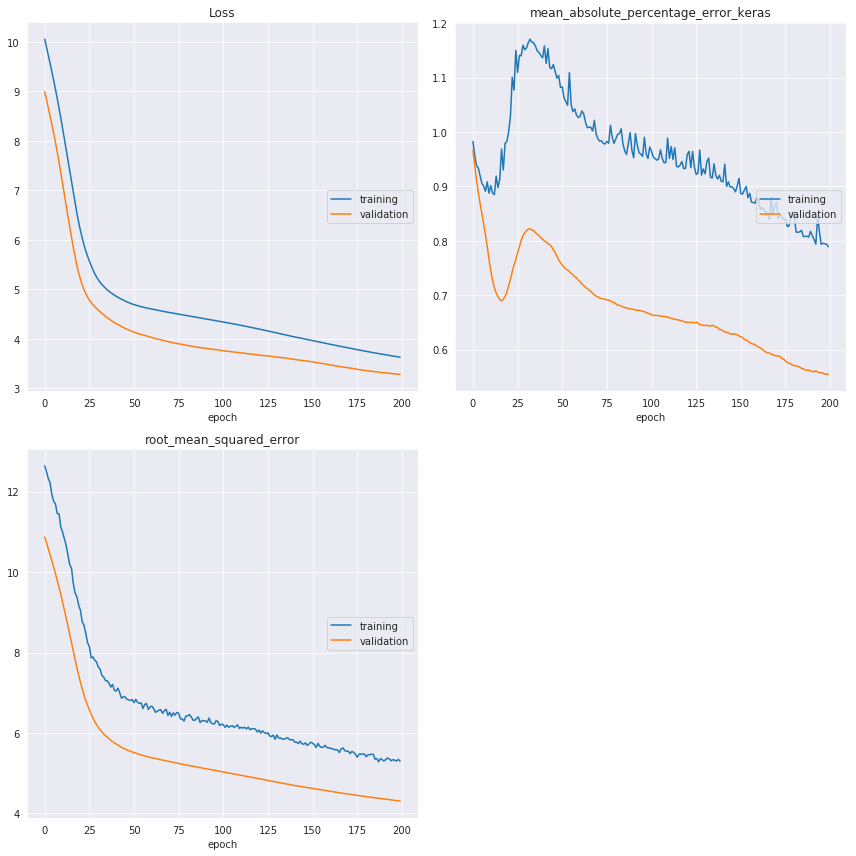

Loss
	training         	 (min:    3.632, max:   10.056, cur:    3.632)
	validation       	 (min:    3.283, max:    8.997, cur:    3.283)
mean_absolute_percentage_error_keras
	training         	 (min:    0.789, max:    1.170, cur:    0.789)
	validation       	 (min:    0.554, max:    0.967, cur:    0.554)
root_mean_squared_error
	training         	 (min:    5.283, max:   12.643, cur:    5.298)
	validation       	 (min:    4.307, max:   10.874, cur:    4.307)


In [59]:
clf_list = []
chunksize = 1000 if data_size > 10000 else max(data_size//10, min(50, data_size))
X_data_list_splits = list(chunks(X_data_list, chunksize))
y_data_list_splits = list(chunks(y_data_list, chunksize))

max_seed = 2**32 - 1
seed_list = random.sample(range(0, max_seed), number_different_lambda_trainings)
chunk_multiplier = 0

for X_data_list_split, y_data_list_split in tqdm(zip(X_data_list_splits, y_data_list_splits), total=max(len(X_data_list_splits), len(y_data_list_splits))):
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    clf_sublist = parallel(delayed(train_nn)(chunksize*chunk_multiplier+index, X_data[1].values, y_data[1].values, X_data[0], seed_list, return_history=True, each_epochs_save=each_epochs_save, printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list_split, y_data_list_split)))  
    clf_list.extend(clf_sublist)
    del parallel
    chunk_multiplier +=1
rand_index = np.random.randint(data_size)
random_network = train_nn(rand_index, X_data_list[rand_index][1], y_data_list[rand_index][1], X_data_list[rand_index][0], seed_list, callbacks=[PlotLossesKerasTF()], return_model=True)


## Save Lambda-Model scores

In [60]:
if each_epochs_save == None:
    scores_list_train = [clf[1][1] for clf in clf_list]
    scores_list_valid = [clf[1][2] for clf in clf_list]
    scores_list_test = [clf[1][3] for clf in clf_list]
    scores_list_stds = [clf[1][4] for clf in clf_list]
    scores_list_means = [clf[1][5] for clf in clf_list]

    scores_list_train_mean = pd.DataFrame(scores_list_train, columns=scores_list_train[0].keys()).mean()
    df_mean_scores_train = pd.DataFrame(np.column_stack((scores_list_train_mean.values[0::4], scores_list_train_mean.values[1::4], scores_list_train_mean.values[2::4], scores_list_train_mean.values[3::4])), columns=['TRAIN PRED', 'TRAIN POLY', 'TRAIN POLY PRED', 'TRAIN LSTSQ'], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV'])

    scores_list_valid_mean = pd.DataFrame(scores_list_valid, columns=scores_list_valid[0].keys()).mean()
    df_mean_scores_valid = pd.DataFrame(np.column_stack((scores_list_valid_mean.values[0::4], scores_list_valid_mean.values[1::4], scores_list_valid_mean.values[2::4], scores_list_valid_mean.values[3::4])), columns=['VALID PRED', 'VALID POLY', 'VALID POLY PRED', 'VALID LSTSQ'], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV'])

    scores_list_test_mean = pd.DataFrame(scores_list_test, columns=scores_list_test[0].keys()).mean()
    df_mean_scores_test = pd.DataFrame(np.column_stack((scores_list_test_mean.values[0::4], scores_list_test_mean.values[1::4], scores_list_test_mean.values[2::4], scores_list_test_mean.values[3::4])), columns=['TEST PRED', 'TEST POLY', 'TEST POLY PRED', 'TEST LSTSQ'], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV'])

    stds_mean = pd.DataFrame(scores_list_stds, columns=scores_list_stds[0].keys()).mean()
    df_stds = pd.DataFrame(stds_mean, columns=['0'], index=stds_mean.index)
    
    means_mean = pd.DataFrame(scores_list_means, columns=scores_list_means[0].keys()).mean()
    df_means = pd.DataFrame(means_mean, columns=['0'], index=means_mean.index)
    
    path_scores_train = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_train_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_scores_valid = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_valid_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_scores_test = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_test_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_stds = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/stds_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_means = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/means_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
   
    df_mean_scores_train.to_csv(path_scores_train, sep=',')
    df_mean_scores_valid.to_csv(path_scores_valid, sep=',')
    df_mean_scores_test.to_csv(path_scores_test, sep=',')
    df_stds.to_csv(path_stds, sep=',')
    df_means.to_csv(path_means, sep=',')
else:
    scores_list = [clf[1] for clf in clf_list]
    
    scores_list_by_epochs = [[] for i in epochs_save_range]
    for scores_list in scores_list:   
        for index, scores in enumerate(scores_list):
            scores_list_by_epochs[index].append(scores)
            
        
    for i, scores_list_single_epoch in enumerate(scores_list_by_epochs):
        index = (i+1)*each_epochs_save if each_epochs_save==1 else i*each_epochs_save if i > 1 else each_epochs_save if i==1 else 1
           
        scores_list_train = [scores_list[1] for scores_list in scores_list_single_epoch]
        scores_list_valid = [scores_list[2] for scores_list in scores_list_single_epoch]
        scores_list_test = [scores_list[3] for scores_list in scores_list_single_epoch]
        scores_list_stds = [scores_list[4] for scores_list in scores_list_single_epoch]
        scores_list_means = [scores_list[5] for scores_list in scores_list_single_epoch]
        
        scores_list_train_mean = pd.DataFrame(scores_list_train, columns=scores_list_train[0].keys()).mean()  
        scores_list_valid_mean = pd.DataFrame(scores_list_valid, columns=scores_list_valid[0].keys()).mean()  
        scores_list_test_mean = pd.DataFrame(scores_list_test, columns=scores_list_test[0].keys()).mean()
        stds_mean = pd.DataFrame(scores_list_stds, columns=scores_list_stds[0].keys()).mean()
        means_mean = pd.DataFrame(scores_list_means, columns=scores_list_means[0].keys()).mean()

        if index == 1:
            df_mean_scores_train = pd.DataFrame(np.column_stack((scores_list_train_mean.values[0::4], scores_list_train_mean.values[1::4], scores_list_train_mean.values[2::4], scores_list_train_mean.values[3::4])), columns=['TRAIN PRED E' + str(index), 'TRAIN POLY E' + str(index), 'TRAIN POLY PRED E' + str(index), 'TRAIN LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV'])
            df_mean_scores_valid = pd.DataFrame(np.column_stack((scores_list_valid_mean.values[0::4], scores_list_valid_mean.values[1::4], scores_list_valid_mean.values[2::4], scores_list_valid_mean.values[3::4])), columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index), 'VALID POLY PRED E' + str(index), 'VALID LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV'])
            df_mean_scores_test = pd.DataFrame(np.column_stack((scores_list_test_mean.values[0::4], scores_list_test_mean.values[1::4], scores_list_test_mean.values[2::4], scores_list_test_mean.values[3::4])), columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index), 'TEST POLY PRED E' + str(index), 'TEST LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV'])
            df_stds = pd.DataFrame(stds_mean, columns=['E' + str(index)], index=stds_mean.index)   
            df_means = pd.DataFrame(means_mean, columns=['E' + str(index)], index=means_mean.index)   
        else:
            df_mean_scores_train_new = pd.DataFrame(np.column_stack((scores_list_train_mean.values[0::4], scores_list_train_mean.values[1::4], scores_list_train_mean.values[2::4], scores_list_train_mean.values[3::4])), columns=['TRAIN PRED E' + str(index), 'TRAIN POLY E' + str(index), 'TRAIN POLY PRED E' + str(index), 'TRAIN LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV'])
            df_mean_scores_train = pd.concat([df_mean_scores_train, df_mean_scores_train_new],axis=1)  
            
            df_mean_scores_valid_new = pd.DataFrame(np.column_stack((scores_list_valid_mean.values[0::4], scores_list_valid_mean.values[1::4], scores_list_valid_mean.values[2::4], scores_list_valid_mean.values[3::4])), columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index), 'VALID POLY PRED E' + str(index), 'VALID LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV'])
            df_mean_scores_valid = pd.concat([df_mean_scores_valid, df_mean_scores_valid_new],axis=1)  

            df_mean_scores_test_new = pd.DataFrame(np.column_stack((scores_list_test_mean.values[0::4], scores_list_test_mean.values[1::4], scores_list_test_mean.values[2::4], scores_list_test_mean.values[3::4])), columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index), 'TEST POLY PRED E' + str(index), 'TEST LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV'])
            df_mean_scores_test = pd.concat([df_mean_scores_test, df_mean_scores_test_new],axis=1)  

            df_stds_new = pd.DataFrame(stds_mean, columns=['E' + str(index)], index=stds_mean.index)
            df_stds = pd.concat([df_stds, df_stds_new],axis=1)  
            
            df_means_new = pd.DataFrame(means_mean, columns=['E' + str(index)], index=means_mean.index)
            df_means = pd.concat([df_means, df_means_new],axis=1)     

    path_scores_train = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_train_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_scores_valid = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_valid_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_scores_test = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_test_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_stds = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/stds_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_means = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/means_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

    df_mean_scores_train.to_csv(path_scores_train, sep=',')
    df_mean_scores_valid.to_csv(path_scores_valid, sep=',')
    df_mean_scores_test.to_csv(path_scores_test, sep=',')
    df_stds.to_csv(path_stds, sep=',')
    df_means.to_csv(path_means, sep=',')
        

In [61]:
df_mean_scores_train

,TRAIN PRED E1,TRAIN POLY E1,TRAIN POLY PRED E1,TRAIN LSTSQ E1,TRAIN PRED E10,TRAIN POLY E10,TRAIN POLY PRED E10,TRAIN LSTSQ E10,TRAIN PRED E20,TRAIN POLY E20,...,TRAIN POLY PRED E180,TRAIN LSTSQ E180,TRAIN PRED E190,TRAIN POLY E190,TRAIN POLY PRED E190,TRAIN LSTSQ E190,TRAIN PRED E200,TRAIN POLY E200,TRAIN POLY PRED E200,TRAIN LSTSQ E200
MAE FV,10.176,10.176,0.013,0.000,9.701,9.702,0.015,0.000,8.971,8.973,...,0.363,0.000,4.428,4.464,0.387,0.000,4.340,4.377,0.410,0.000
RMSE FV,12.978,12.978,0.016,0.000,12.487,12.487,0.020,0.000,11.729,11.729,...,0.467,0.000,6.234,6.211,0.495,0.000,6.122,6.096,0.524,0.000
MAPE FV,1.319,1.318,0.402,0.000,1.434,1.433,0.197,0.000,1.816,1.819,...,0.505,0.000,3.057,3.164,0.408,0.000,3.010,3.128,0.465,0.000
R2 FV,-0.400,-0.400,0.999,1.000,-0.283,-0.283,0.999,1.000,-0.114,-0.114,...,0.996,1.000,0.655,0.657,0.995,1.000,0.666,0.669,0.995,1.000
RAAE FV,0.916,0.916,0.022,0.000,0.871,0.871,0.024,0.000,0.803,0.803,...,0.048,0.000,0.408,0.412,0.051,0.000,0.400,0.404,0.054,0.000
RMAE FV,3.461,3.461,0.096,0.000,3.435,3.435,0.116,0.000,3.388,3.387,...,0.241,0.000,2.375,2.328,0.249,0.000,2.347,2.296,0.258,0.000


In [62]:
df_mean_scores_valid

,VALID PRED E1,VALID POLY E1,VALID POLY PRED E1,VALID LSTSQ E1,VALID PRED E10,VALID POLY E10,VALID POLY PRED E10,VALID LSTSQ E10,VALID PRED E20,VALID POLY E20,...,VALID POLY PRED E180,VALID LSTSQ E180,VALID PRED E190,VALID POLY E190,VALID POLY PRED E190,VALID LSTSQ E190,VALID PRED E200,VALID POLY E200,VALID POLY PRED E200,VALID LSTSQ E200
MAE FV,10.195,10.195,0.014,0.000,9.724,9.724,0.017,0.000,9.000,9.002,...,0.388,0.000,4.553,4.568,0.413,0.000,4.469,4.483,0.438,0.000
RMSE FV,13.004,13.004,0.018,0.000,12.516,12.516,0.022,0.000,11.765,11.764,...,0.507,0.000,6.342,6.301,0.537,0.000,6.236,6.189,0.568,0.000
MAPE FV,65.298,67.076,0.206,0.000,113.807,115.506,0.218,0.000,193.826,196.015,...,0.477,0.000,256.837,252.637,0.467,0.000,264.414,258.485,0.503,0.000
R2 FV,-0.413,-0.413,0.999,1.000,-0.294,-0.294,0.999,1.000,-0.125,-0.124,...,0.995,1.000,0.642,0.646,0.994,1.000,0.653,0.658,0.994,1.000
RAAE FV,0.920,0.920,0.024,0.000,0.875,0.875,0.026,0.000,0.807,0.807,...,0.052,0.000,0.420,0.422,0.055,0.000,0.413,0.414,0.058,0.000
RMAE FV,3.019,3.019,0.097,0.000,2.993,2.993,0.112,0.000,2.948,2.947,...,0.228,0.000,2.010,1.968,0.237,0.000,1.985,1.939,0.247,0.000


In [63]:
df_mean_scores_test

,TEST PRED E1,TEST POLY E1,TEST POLY PRED E1,TEST LSTSQ E1,TEST PRED E10,TEST POLY E10,TEST POLY PRED E10,TEST LSTSQ E10,TEST PRED E20,TEST POLY E20,...,TEST POLY PRED E180,TEST LSTSQ E180,TEST PRED E190,TEST POLY E190,TEST POLY PRED E190,TEST LSTSQ E190,TEST PRED E200,TEST POLY E200,TEST POLY PRED E200,TEST LSTSQ E200
MAE FV,10.198,10.198,0.014,0.000,9.726,9.727,0.017,0.000,9.004,9.005,...,0.388,0.000,4.548,4.562,0.413,0.000,4.464,4.477,0.438,0.000
RMSE FV,13.006,13.006,0.018,0.000,12.518,12.517,0.022,0.000,11.765,11.765,...,0.508,0.000,6.343,6.300,0.539,0.000,6.237,6.189,0.570,0.000
MAPE FV,1.205,1.205,0.242,0.000,1.287,1.287,0.175,0.000,1.539,1.541,...,0.463,0.000,2.317,2.335,0.360,0.000,2.282,2.304,0.619,0.000
R2 FV,-0.413,-0.413,0.999,1.000,-0.294,-0.294,0.999,1.000,-0.125,-0.125,...,0.995,1.000,0.642,0.646,0.994,1.000,0.653,0.658,0.994,1.000
RAAE FV,0.920,0.920,0.024,0.000,0.875,0.875,0.026,0.000,0.807,0.807,...,0.052,0.000,0.420,0.421,0.055,0.000,0.412,0.413,0.058,0.000
RMAE FV,3.142,3.142,0.101,0.000,3.116,3.116,0.119,0.000,3.070,3.070,...,0.245,0.000,2.124,2.078,0.255,0.000,2.098,2.048,0.265,0.000


In [64]:
df_stds

,E1,E10,E20,E30,E40,E50,E60,E70,E80,E90,...,E110,E120,E130,E140,E150,E160,E170,E180,E190,E200
STD FV TRAIN REAL LAMBDA,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,...,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220
STD FV TRAIN PRED LAMBDA,0.574,0.666,1.010,1.655,2.531,3.481,4.386,5.165,5.787,6.271,...,6.931,7.156,7.336,7.484,7.608,7.716,7.814,7.904,7.991,8.073
STD FV TRAIN PRED LAMBDA POLY LSTSQ,0.574,0.666,1.010,1.655,2.530,3.479,4.384,5.162,5.784,6.266,...,6.924,7.148,7.327,7.474,7.597,7.704,7.800,7.889,7.974,8.054
STD FV TRAIN REAL LAMBDA POLY LSTSQ,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,...,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220,11.220
STD FV VALID REAL LAMBDA,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,...,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210
STD FV VALID PRED LAMBDA,0.573,0.664,1.007,1.646,2.515,3.458,4.358,5.133,5.752,6.234,...,6.893,7.118,7.297,7.444,7.567,7.674,7.770,7.859,7.945,8.025
STD FV VALID PRED LAMBDA POLY LSTSQ,0.573,0.664,1.006,1.646,2.514,3.457,4.356,5.131,5.750,6.231,...,6.888,7.112,7.290,7.437,7.559,7.665,7.760,7.848,7.933,8.012
STD FV VALID REAL LAMBDA POLY LSTSQ,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,...,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210,11.210
STD FV TEST REAL LAMBDA,11.208,11.208,11.208,11.208,11.208,11.208,11.208,11.208,11.208,11.208,...,11.208,11.208,11.208,11.208,11.208,11.208,11.208,11.208,11.208,11.208
STD FV TEST PRED LAMBDA,0.575,0.665,1.008,1.649,2.521,3.466,4.369,5.146,5.767,6.250,...,6.909,7.133,7.312,7.458,7.581,7.687,7.782,7.870,7.955,8.035


In [65]:
df_means

,E1,E10,E20,E30,E40,E50,E60,E70,E80,E90,...,E110,E120,E130,E140,E150,E160,E170,E180,E190,E200
MEAN FV TRAIN REAL LAMBDA,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,...,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183
MEAN FV TRAIN PRED LAMBDA,0.005,-0.017,-0.038,-0.066,-0.136,-0.184,-0.193,-0.195,-0.197,-0.201,...,-0.196,-0.191,-0.186,-0.183,-0.179,-0.178,-0.178,-0.178,-0.181,-0.180
MEAN FV TRAIN PRED LAMBDA POLY LSTSQ,0.005,-0.017,-0.038,-0.066,-0.136,-0.184,-0.193,-0.195,-0.197,-0.201,...,-0.196,-0.191,-0.186,-0.183,-0.179,-0.178,-0.178,-0.178,-0.181,-0.180
MEAN FV TRAIN REAL LAMBDA POLY LSTSQ,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,...,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183,-0.183
MEAN FV VALID REAL LAMBDA,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,...,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239
MEAN FV VALID PRED LAMBDA,0.005,-0.017,-0.041,-0.075,-0.154,-0.212,-0.230,-0.238,-0.244,-0.252,...,-0.250,-0.245,-0.240,-0.236,-0.233,-0.233,-0.233,-0.234,-0.237,-0.236
MEAN FV VALID PRED LAMBDA POLY LSTSQ,0.005,-0.017,-0.041,-0.075,-0.154,-0.212,-0.230,-0.237,-0.244,-0.251,...,-0.249,-0.244,-0.239,-0.235,-0.232,-0.232,-0.232,-0.232,-0.235,-0.233
MEAN FV VALID REAL LAMBDA POLY LSTSQ,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,...,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239
MEAN FV TEST REAL LAMBDA,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225,...,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225,-0.225
MEAN FV TEST PRED LAMBDA,0.006,-0.017,-0.039,-0.069,-0.141,-0.192,-0.204,-0.208,-0.212,-0.220,...,-0.221,-0.218,-0.214,-0.211,-0.208,-0.208,-0.209,-0.209,-0.212,-0.212


## Save Lambda-Net Predictions

In [66]:
def save_lambda_preds(i, 
                      lambda_indices,
                      y_train_real_lambda_by_epoch, 
                      y_train_pred_lambda_by_epoch, 
                      y_train_pred_lambda_poly_lstsq_by_epoch, 
                      X_train_lambda_by_epoch, 
                      y_valid_real_lambda_by_epoch, 
                      y_valid_pred_lambda_by_epoch, 
                      y_valid_pred_lambda_poly_lstsq_by_epoch, 
                      X_valid_lambda_by_epoch, 
                      y_test_real_lambda_by_epoch, 
                      y_test_pred_lambda_by_epoch, 
                      y_test_pred_lambda_poly_lstsq_by_epoch, 
                      X_test_lambda_by_epoch):
    
    
    index = (i+1)*each_epochs_save if each_epochs_save==1 else i*each_epochs_save if i > 1 else each_epochs_save if i==1 else 1
        
    y_train_real_lambda_df = pd.DataFrame([np.concatenate([X_train_lambda, y_train_real_lambda], axis=1).ravel() for X_train_lambda, y_train_real_lambda in zip(X_train_lambda_by_epoch, y_train_real_lambda_by_epoch)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_train_lambda_by_epoch[0].shape[0])]).ravel())
    y_valid_real_lambda_df = pd.DataFrame([np.concatenate([X_valid_lambda, y_valid_real_lambda], axis=1).ravel() for X_valid_lambda, y_valid_real_lambda in zip(X_valid_lambda_by_epoch, y_valid_real_lambda_by_epoch)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_valid_lambda_by_epoch[0].shape[0])]).ravel())
    y_test_real_lambda_df = pd.DataFrame([np.concatenate([X_test_lambda, y_test_real_lambda], axis=1).ravel() for X_test_lambda, y_test_real_lambda in zip(X_test_lambda_by_epoch, y_test_real_lambda_by_epoch)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_test_lambda_by_epoch[0].shape[0])]).ravel())
    y_train_pred_lambda_df = pd.DataFrame([np.concatenate([X_train_lambda, y_train_pred_lambda], axis=1).ravel() for X_train_lambda, y_train_pred_lambda in zip(X_train_lambda_by_epoch, y_train_pred_lambda_by_epoch)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_train_lambda_by_epoch[0].shape[0])]).ravel())
    y_valid_pred_lambda_df = pd.DataFrame([np.concatenate([X_valid_lambda, y_valid_pred_lambda], axis=1).ravel() for X_valid_lambda, y_valid_pred_lambda in zip(X_valid_lambda_by_epoch, y_valid_pred_lambda_by_epoch)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_valid_lambda_by_epoch[0].shape[0])]).ravel())
    y_test_pred_lambda_df = pd.DataFrame([np.concatenate([X_test_lambda, y_test_pred_lambda], axis=1).ravel() for X_test_lambda, y_test_pred_lambda in zip(X_test_lambda_by_epoch, y_test_pred_lambda_by_epoch)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_test_lambda_by_epoch[0].shape[0])]).ravel())
    y_train_pred_lambda_poly_lstsq_df = pd.DataFrame([np.concatenate([X_train_lambda, y_train_pred_lambda_poly_lstsq], axis=1).ravel() for X_train_lambda, y_train_pred_lambda_poly_lstsq in zip(X_train_lambda_by_epoch, y_train_pred_lambda_poly_lstsq_by_epoch)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_train_lambda_by_epoch[0].shape[0])]).ravel())
    y_valid_pred_lambda_poly_lstsq_df = pd.DataFrame([np.concatenate([X_valid_lambda, y_valid_pred_lambda_poly_lstsq], axis=1).ravel() for X_valid_lambda, y_valid_pred_lambda_poly_lstsq in zip(X_valid_lambda_by_epoch, y_valid_pred_lambda_poly_lstsq_by_epoch)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_valid_lambda_by_epoch[0].shape[0])]).ravel())
    y_test_pred_lambda_poly_lstsq_df = pd.DataFrame([np.concatenate([X_test_lambda, y_test_pred_lambda_poly_lstsq], axis=1).ravel() for X_test_lambda, y_test_pred_lambda_poly_lstsq in zip(X_test_lambda_by_epoch, y_test_pred_lambda_poly_lstsq_by_epoch)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_test_lambda_by_epoch[0].shape[0])]).ravel())    

    y_train_real_lambda_df = pd.concat([pd.DataFrame(lambda_indices, columns=['lambda_index']), pd.concat([polynomial_real_df, y_train_real_lambda_df], axis=1)], axis=1)
    y_valid_real_lambda_df = pd.concat([pd.DataFrame(lambda_indices, columns=['lambda_index']), pd.concat([polynomial_real_df, y_valid_real_lambda_df], axis=1)], axis=1)
    y_test_real_lambda_df = pd.concat([pd.DataFrame(lambda_indices, columns=['lambda_index']), pd.concat([polynomial_real_df, y_test_real_lambda_df], axis=1)], axis=1)
    y_train_pred_lambda_df = pd.concat([pd.DataFrame(lambda_indices, columns=['lambda_index']), pd.concat([polynomial_real_df, y_train_pred_lambda_df], axis=1)], axis=1)
    y_valid_pred_lambda_df = pd.concat([pd.DataFrame(lambda_indices, columns=['lambda_index']), pd.concat([polynomial_real_df, y_valid_pred_lambda_df], axis=1)], axis=1)
    y_test_pred_lambda_df = pd.concat([pd.DataFrame(lambda_indices, columns=['lambda_index']), pd.concat([polynomial_real_df, y_test_pred_lambda_df], axis=1)], axis=1)
    y_train_pred_lambda_poly_lstsq_df = pd.concat([pd.DataFrame(lambda_indices, columns=['lambda_index']), pd.concat([polynomial_real_df, y_train_pred_lambda_poly_lstsq_df], axis=1)], axis=1)
    y_valid_pred_lambda_poly_lstsq_df = pd.concat([pd.DataFrame(lambda_indices, columns=['lambda_index']), pd.concat([polynomial_real_df, y_valid_pred_lambda_poly_lstsq_df], axis=1)], axis=1)
    y_test_pred_lambda_poly_lstsq_df = pd.concat([pd.DataFrame(lambda_indices, columns=['lambda_index']), pd.concat([polynomial_real_df, y_test_pred_lambda_poly_lstsq_df], axis=1)], axis=1)

    path_y_train_real_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_real_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_valid_real_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_real_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_test_real_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_real_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_train_pred_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_pred_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_valid_pred_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_pred_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_test_pred_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_pred_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_train_pred_lambda_poly_lstsq = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_pred_lambda_poly_lstsq_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_valid_pred_lambda_poly_lstsq = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_pred_lambda_poly_lstsq_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_test_pred_lambda_poly_lstsq = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_pred_lambda_poly_lstsq_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

    y_train_real_lambda_df.to_csv(path_y_train_real_lambda, sep=',', index=False)
    y_valid_real_lambda_df.to_csv(path_y_valid_real_lambda, sep=',', index=False)
    y_test_real_lambda_df.to_csv(path_y_test_real_lambda, sep=',', index=False)         
    y_train_pred_lambda_df.to_csv(path_y_train_pred_lambda, sep=',', index=False)
    y_valid_pred_lambda_df.to_csv(path_y_valid_pred_lambda, sep=',', index=False)
    y_test_pred_lambda_df.to_csv(path_y_test_pred_lambda, sep=',', index=False)    
    y_train_pred_lambda_poly_lstsq_df.to_csv(path_y_train_pred_lambda_poly_lstsq, sep=',', index=False)
    y_valid_pred_lambda_poly_lstsq_df.to_csv(path_y_valid_pred_lambda_poly_lstsq, sep=',', index=False)
    y_test_pred_lambda_poly_lstsq_df.to_csv(path_y_test_pred_lambda_poly_lstsq, sep=',', index=False) 

    return y_train_real_lambda_df, y_valid_real_lambda_df, y_test_real_lambda_df, y_train_pred_lambda_df, y_valid_pred_lambda_df, y_test_pred_lambda_df, y_train_pred_lambda_poly_lstsq_df, y_valid_pred_lambda_poly_lstsq_df, y_test_pred_lambda_poly_lstsq_df
    

In [67]:
if each_epochs_save == None:
    
    variable_names = 'abcdefghijklmnopqrstuvwxyz'
    variable_names_list = [variable + '_' for variable in variable_names[:n]]
    variable_names_list.append('FV_')
    
    lambda_index_list = [clf[0][0] for clf in clf_list]
    lambda_seed_list = [clf[0][1] for clf in clf_list] 
    polynomial_real_list = [clf[0][2] for clf in clf_list] 
    polynomial_lstsq_pred_lambda_list = [clf[0][3] for clf in clf_list] 
    polynomial_lstsq_real_lambda_list = [clf[0][4] for clf in clf_list] 
    
    polynomial_real_df = pd.DataFrame(polynomial_real_list)

    lambda_indices_list = np.zeros((len(clf_list), 1))
    y_train_real_lambda_list = np.zeros((len(clf_list), len(clf_list[0][2][1])))
    y_train_pred_lambda_list = np.zeros((len(clf_list), len(clf_list[0][2][2])))
    y_train_pred_lambda_poly_lstsq_list = np.zeros((len(clf_list), len(clf_list[0][2][3])))
    X_train_lambda_list = np.zeros([(a, *rest) for a, rest in [(len(clf_list), clf_list[0][2][4].shape)]][0])
    y_valid_real_lambda_list = np.zeros((len(clf_list), len(clf_list[0][2][5])))
    y_valid_pred_lambda_list = np.zeros((len(clf_list), len(clf_list[0][2][6])))
    y_valid_pred_lambda_poly_lstsq_list = np.zeros((len(clf_list), len(clf_list[0][2][7])))
    X_valid_lambda_list = np.zeros([(a, *rest) for a, rest in [(len(clf_list), clf_list[0][2][8].shape)]][0])
    y_test_real_lambda_list = np.zeros((len(clf_list), len(clf_list[0][2][9])))
    y_test_pred_lambda_list = np.zeros((len(clf_list), len(clf_list[0][2][10])))
    y_test_pred_lambda_poly_lstsq_list = np.zeros((len(clf_list), len(clf_list[0][2][11])))
    X_test_lambda_list = np.zeros([(a, *rest) for a, rest in [(len(clf_list), clf_list[0][2][12].shape)]][0])

    for index, (lambda_indices, y_train_real_lambda, y_train_pred_lambda, y_train_pred_lambda_poly_lstsq, X_train_lambda, y_valid_real_lambda, y_valid_pred_lambda, y_valid_pred_lambda_poly_lstsq, X_valid_lambda, y_test_real_lambda, y_test_pred_lambda, y_test_pred_lambda_poly_lstsq, X_test_lambda) in enumerate([clf[2] for clf in clf_list]):
        lambda_indices_list[index] = lambda_indices
        y_train_real_lambda_list[index] = y_train_real_lambda.ravel()
        y_train_pred_lambda_list[index] = y_train_pred_lambda.ravel()
        y_train_pred_lambda_poly_lstsq_list[index] = y_train_pred_lambda_poly_lstsq.ravel()
        X_train_lambda_list[index] = X_train_lambda#.ravel()

        y_valid_real_lambda_list[index] = y_valid_real_lambda.ravel()
        y_valid_pred_lambda_list[index] = y_valid_pred_lambda.ravel()
        y_valid_pred_lambda_poly_lstsq_list[index] = y_valid_pred_lambda_poly_lstsq.ravel()
        X_valid_lambda_list[index] = X_valid_lambda#.ravel()

        y_test_real_lambda_list[index] = y_test_real_lambda.ravel()
        y_test_pred_lambda_list[index] = y_test_pred_lambda.ravel()
        y_test_pred_lambda_poly_lstsq_list[index] = y_test_pred_lambda_poly_lstsq.ravel()
        X_test_lambda_list[index] = X_test_lambda#.ravel()
    
    #add x_data before each pred
    y_train_real_lambda_df = pd.DataFrame([np.concatenate([X_train_lambda, y_train_real_lambda.reshape(len(y_train_real_lambda),1)], axis=1).ravel() for X_train_lambda, y_train_real_lambda in zip(X_train_lambda_list, y_train_real_lambda_list)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_train_lambda_list[0].shape[0])]).ravel())
    y_valid_real_lambda_df = pd.DataFrame([np.concatenate([X_valid_lambda, y_valid_real_lambda.reshape(len(y_valid_real_lambda),1)], axis=1).ravel() for X_valid_lambda, y_valid_real_lambda in zip(X_valid_lambda_list, y_valid_real_lambda_list)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_valid_lambda_list[0].shape[0])]).ravel())
    y_test_real_lambda_df = pd.DataFrame([np.concatenate([X_test_lambda, y_test_real_lambda.reshape(len(y_test_real_lambda),1)], axis=1).ravel() for X_test_lambda, y_test_real_lambda in zip(X_test_lambda_list, y_test_real_lambda_list)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_test_lambda_list[0].shape[0])]).ravel())
    y_train_pred_lambda_df = pd.DataFrame([np.concatenate([X_train_lambda, y_train_pred_lambda.reshape(len(y_train_pred_lambda),1)], axis=1).ravel() for X_train_lambda, y_train_pred_lambda in zip(X_train_lambda_list, y_train_pred_lambda_list)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_train_lambda_list[0].shape[0])]).ravel())
    y_valid_pred_lambda_df = pd.DataFrame([np.concatenate([X_valid_lambda, y_valid_pred_lambda.reshape(len(y_valid_pred_lambda),1)], axis=1).ravel() for X_valid_lambda, y_valid_pred_lambda in zip(X_valid_lambda_list, y_valid_pred_lambda_list)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_valid_lambda_list[0].shape[0])]).ravel())
    y_test_pred_lambda_df = pd.DataFrame([np.concatenate([X_test_lambda, y_test_pred_lambda.reshape(len(y_test_pred_lambda),1)], axis=1).ravel() for X_test_lambda, y_test_pred_lambda in zip(X_test_lambda_list, y_test_pred_lambda_list)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_test_lambda_list[0].shape[0])]).ravel())
    y_train_pred_lambda_poly_lstsq_df = pd.DataFrame([np.concatenate([X_train_lambda, y_train_pred_lambda_poly_lstsq.reshape(len(y_train_pred_lambda_poly_lstsq),1)], axis=1).ravel() for X_train_lambda, y_train_pred_lambda_poly_lstsq in zip(X_train_lambda_list, y_train_pred_lambda_poly_lstsq_list)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_train_lambda_list[0].shape[0])]).ravel())
    y_valid_pred_lambda_poly_lstsq_df = pd.DataFrame([np.concatenate([X_valid_lambda, y_valid_pred_lambda_poly_lstsq.reshape(len(y_valid_pred_lambda_poly_lstsq),1)], axis=1).ravel() for X_valid_lambda, y_valid_pred_lambda_poly_lstsq in zip(X_valid_lambda_list, y_valid_pred_lambda_poly_lstsq_list)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_valid_lambda_list[0].shape[0])]).ravel())
    y_test_pred_lambda_poly_lstsq_df = pd.DataFrame([np.concatenate([X_test_lambda, y_test_pred_lambda_poly_lstsq.reshape(len(y_test_pred_lambda_poly_lstsq),1)], axis=1).ravel() for X_test_lambda, y_test_pred_lambda_poly_lstsq in zip(X_test_lambda_list, y_test_pred_lambda_poly_lstsq_list)], columns=np.array([[variable_name + str(i+1) for variable_name in variable_names_list] for i in range(X_test_lambda_list[0].shape[0])]).ravel())    
    
    y_train_real_lambda_df = pd.concat([pd.DataFrame(lambda_indices_list, columns=['lambda_index']), pd.concat([polynomial_real_df, y_train_real_lambda_df], axis=1)], axis=1)
    y_valid_real_lambda_df = pd.concat([pd.DataFrame(lambda_indices_list, columns=['lambda_index']), pd.concat([polynomial_real_df, y_valid_real_lambda_df], axis=1)], axis=1)
    y_test_real_lambda_df = pd.concat([pd.DataFrame(lambda_indices_list, columns=['lambda_index']), pd.concat([polynomial_real_df, y_test_real_lambda_df], axis=1)], axis=1)
    y_train_pred_lambda_df = pd.concat([pd.DataFrame(lambda_indices_list, columns=['lambda_index']), pd.concat([polynomial_real_df, y_train_pred_lambda_df], axis=1)], axis=1)
    y_valid_pred_lambda_df = pd.concat([pd.DataFrame(lambda_indices_list, columns=['lambda_index']), pd.concat([polynomial_real_df, y_valid_pred_lambda_df], axis=1)], axis=1)
    y_test_pred_lambda_df = pd.concat([pd.DataFrame(lambda_indices_list, columns=['lambda_index']), pd.concat([polynomial_real_df, y_test_pred_lambda_df], axis=1)], axis=1)
    y_train_pred_lambda_poly_lstsq_df = pd.concat([pd.DataFrame(lambda_indices_list, columns=['lambda_index']), pd.concat([polynomial_real_df, y_train_pred_lambda_poly_lstsq_df], axis=1)], axis=1)
    y_valid_pred_lambda_poly_lstsq_df = pd.concat([pd.DataFrame(lambda_indices_list, columns=['lambda_index']), pd.concat([polynomial_real_df, y_valid_pred_lambda_poly_lstsq_df], axis=1)], axis=1)
    y_test_pred_lambda_poly_lstsq_df = pd.concat([pd.DataFrame(lambda_indices_list, columns=['lambda_index']), pd.concat([polynomial_real_df, y_test_pred_lambda_poly_lstsq_df], axis=1)], axis=1)
       
    path_y_train_real_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_real_lambda_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_valid_real_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_real_lambda_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_test_real_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_real_lambda_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_train_pred_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_pred_lambda_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_valid_pred_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_pred_lambda_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_test_pred_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_pred_lambda_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_train_pred_lambda_poly_lstsq = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_pred_lambda_poly_lstsq_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_valid_pred_lambda_poly_lstsq = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_pred_lambda_poly_lstsq_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_y_test_pred_lambda_poly_lstsq = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_pred_lambda_poly_lstsq_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
   
    y_train_real_lambda_df.to_csv(path_y_train_real_lambda, sep=',', index=False)
    y_valid_real_lambda_df.to_csv(path_y_valid_real_lambda, sep=',', index=False)
    y_test_real_lambda_df.to_csv(path_y_test_real_lambda, sep=',', index=False)
    y_train_pred_lambda_df.to_csv(path_y_train_pred_lambda, sep=',', index=False)
    y_valid_pred_lambda_df.to_csv(path_y_valid_pred_lambda, sep=',', index=False)
    y_test_pred_lambda_df.to_csv(path_y_test_pred_lambda, sep=',', index=False)
    y_train_pred_lambda_poly_lstsq_df.to_csv(path_y_train_pred_lambda_poly_lstsq, sep=',', index=False)
    y_valid_pred_lambda_poly_lstsq_df.to_csv(path_y_valid_pred_lambda_poly_lstsq, sep=',', index=False)
    y_test_pred_lambda_poly_lstsq_df.to_csv(path_y_test_pred_lambda_poly_lstsq, sep=',', index=False)
    
else:
    variable_names = 'abcdefghijklmnopqrstuvwxyz'
    variable_names_list = [variable + '_' for variable in variable_names[:n]]
    variable_names_list.append('FV_')
    
    polynomial_real_list = [clf[0][0] for clf in clf_list]
    polynomial_lstsq_pred_lambda_list = [clf[0][1] for clf in clf_list]
    polynomial_lstsq_real_lambda_list = [clf[0][2] for clf in clf_list]
    
    polynomial_real_df = pd.DataFrame(polynomial_real_list)
    
    lambda_indices_list = [np.zeros((len(clf_list), 1)) for i in epochs_save_range]
    y_train_real_lambda_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][1]), 1)) for i in epochs_save_range]
    y_train_pred_lambda_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][2]), 1)) for i in epochs_save_range]
    y_train_pred_lambda_poly_lstsq_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][3]), 1)) for i in epochs_save_range]
    X_train_lambda_list = [np.zeros([(a, *rest) for a, rest in [(len(clf_list), clf_list[0][2][0][4].shape)]][0]) for i in epochs_save_range]
    y_valid_real_lambda_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][5]), 1)) for i in epochs_save_range]
    y_valid_pred_lambda_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][6]), 1)) for i in epochs_save_range]
    y_valid_pred_lambda_poly_lstsq_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][7]), 1)) for i in epochs_save_range]
    X_valid_lambda_list = [np.zeros([(a, *rest) for a, rest in [(len(clf_list), clf_list[0][2][0][8].shape)]][0]) for i in epochs_save_range]
    y_test_real_lambda_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][9]), 1)) for i in epochs_save_range]
    y_test_pred_lambda_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][10]), 1)) for i in epochs_save_range]
    y_test_pred_lambda_poly_lstsq_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][12]), 1)) for i in epochs_save_range]
    X_test_lambda_list = [np.zeros([(a, *rest) for a, rest in [(len(clf_list), clf_list[0][2][0][12].shape)]][0]) for i in epochs_save_range]
    
    for i, y_data_list_per_epoch in tqdm(enumerate([clf[2] for clf in clf_list]), total=len(clf_list)):
        
        for index, (lambda_indices, y_train_real_lambda, y_train_pred_lambda, y_train_pred_lambda_poly_lstsq, X_train_lambda, y_valid_real_lambda, y_valid_pred_lambda, y_valid_pred_lambda_poly_lstsq, X_valid_lambda, y_test_real_lambda, y_test_pred_lambda, y_test_pred_lambda_poly_lstsq, X_test_lambda) in enumerate(y_data_list_per_epoch):
            lambda_indices_list[index][i] = lambda_indices
            y_train_real_lambda_list[index][i] = y_train_real_lambda#.ravel()
            y_train_pred_lambda_list[index][i] = y_train_pred_lambda#.ravel()
            y_train_pred_lambda_poly_lstsq_list[index][i] = y_train_pred_lambda_poly_lstsq#.ravel()
            X_train_lambda_list[index][i] = X_train_lambda#.ravel()
            
            y_valid_real_lambda_list[index][i] = y_valid_real_lambda#.ravel()
            y_valid_pred_lambda_list[index][i] = y_valid_pred_lambda#.ravel()
            y_valid_pred_lambda_poly_lstsq_list[index][i] = y_valid_pred_lambda_poly_lstsq#.ravel()
            X_valid_lambda_list[index][i] = X_valid_lambda#.ravel()
            
            y_test_real_lambda_list[index][i] = y_test_real_lambda#.ravel()
            y_test_pred_lambda_list[index][i] = y_test_pred_lambda#.ravel()
            y_test_pred_lambda_poly_lstsq_list[index][i] = y_test_pred_lambda_poly_lstsq#.ravel()
            X_test_lambda_list[index][i] = X_test_lambda#.ravel()
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    y_data_lambda_list = parallel(delayed(save_lambda_preds)(i, 
                                                           lambda_indices,
                                                           y_train_real_lambda_by_epoch, 
                                                           y_train_pred_lambda_by_epoch, 
                                                           y_train_pred_lambda_poly_lstsq_by_epoch, 
                                                           X_train_lambda_by_epoch, 
                                                           y_valid_real_lambda_by_epoch, 
                                                           y_valid_pred_lambda_by_epoch, 
                                                           y_valid_pred_lambda_poly_lstsq_by_epoch, 
                                                           X_valid_lambda_by_epoch, 
                                                           y_test_real_lambda_by_epoch, 
                                                           y_test_pred_lambda_by_epoch, 
                                                           y_test_pred_lambda_poly_lstsq_by_epoch, 
                                                           X_test_lambda_by_epoch) for i, 
                                                                                        (lambda_indices,
                                                                                         y_train_real_lambda_by_epoch, 
                                                                                         y_train_pred_lambda_by_epoch, 
                                                                                         y_train_pred_lambda_poly_lstsq_by_epoch, 
                                                                                         X_train_lambda_by_epoch, 
                                                                                         y_valid_real_lambda_by_epoch, 
                                                                                         y_valid_pred_lambda_by_epoch, 
                                                                                         y_valid_pred_lambda_poly_lstsq_by_epoch, 
                                                                                         X_valid_lambda_by_epoch, 
                                                                                         y_test_real_lambda_by_epoch, 
                                                                                         y_test_pred_lambda_by_epoch, 
                                                                                         y_test_pred_lambda_poly_lstsq_by_epoch, 
                                                                                         X_test_lambda_by_epoch) in enumerate(zip(lambda_indices_list,
                                                                                                                                  y_train_real_lambda_list, 
                                                                                                                                  y_train_pred_lambda_list, 
                                                                                                                                  y_train_pred_lambda_poly_lstsq_list, 
                                                                                                                                  X_train_lambda_list, 
                                                                                                                                  y_valid_real_lambda_list, 
                                                                                                                                  y_valid_pred_lambda_list, 
                                                                                                                                  y_valid_pred_lambda_poly_lstsq_list, 
                                                                                                                                  X_valid_lambda_list, 
                                                                                                                                  y_test_real_lambda_list, 
                                                                                                                                  y_test_pred_lambda_list, 
                                                                                                                                  y_test_pred_lambda_poly_lstsq_list, 
                                                                                                                                  X_test_lambda_list)))  
    y_test_real_lambda_df = y_data_lambda_list[-1][2]
    y_test_pred_lambda_df = y_data_lambda_list[-1][5]
    y_test_pred_lambda_poly_lstsq_df = y_data_lambda_list[-1][8]
    del parallel
    

[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   2 out of  21 | elapsed:  1.0min remaining:  9.6min
[Parallel(n_jobs=-3)]: Done  10 out of  21 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-3)]: Done  18 out of  21 | elapsed:  1.2min remaining:   11.9s
[Parallel(n_jobs=-3)]: Done  21 out of  21 | elapsed:  1.2min finished


In [68]:
y_test_real_lambda_df.head()

,lambda_index,0,a_1,b_1,c_1,d_1,FV_1,a_2,b_2,c_2,...,a_249,b_249,c_249,d_249,FV_249,a_250,b_250,c_250,d_250,FV_250
0,0.000,0,0.430,0.220,0.880,-0.930,-29.297,0.590,-0.960,0.760,...,0.470,-0.760,-0.550,-0.700,-0.225,-0.190,-0.540,0.170,-0.010,1.967
1,1.000,1,-0.750,-0.060,-0.440,-0.880,-35.619,0.930,0.370,-0.170,...,-0.890,-0.450,0.710,0.240,-2.749,-0.330,-0.410,-0.400,-0.710,-26.317
2,2.000,2,0.970,-0.720,-0.560,0.900,-9.850,-0.520,-0.890,0.340,...,-0.490,0.330,-0.100,0.000,-11.731,-0.010,-0.010,0.270,-0.290,-12.293
3,3.000,3,0.680,-0.810,-0.190,-0.780,14.664,0.380,-0.550,-0.180,...,0.430,-0.750,0.220,0.150,5.818,-0.810,0.490,-0.810,0.660,-22.838
4,4.000,4,-0.170,-0.730,0.610,0.430,-7.303,0.060,0.230,0.320,...,0.610,0.920,-0.870,0.560,1.802,-0.790,-0.760,-0.040,-0.770,19.133


In [69]:
y_test_pred_lambda_df.head()

,lambda_index,0,a_1,b_1,c_1,d_1,FV_1,a_2,b_2,c_2,...,a_249,b_249,c_249,d_249,FV_249,a_250,b_250,c_250,d_250,FV_250
0,0.000,0,0.430,0.220,0.880,-0.930,-5.386,0.590,-0.960,0.760,...,0.470,-0.760,-0.550,-0.700,-3.223,-0.190,-0.540,0.170,-0.010,-5.478
1,1.000,1,-0.750,-0.060,-0.440,-0.880,-34.910,0.930,0.370,-0.170,...,-0.890,-0.450,0.710,0.240,-7.374,-0.330,-0.410,-0.400,-0.710,-27.513
2,2.000,2,0.970,-0.720,-0.560,0.900,-0.736,-0.520,-0.890,0.340,...,-0.490,0.330,-0.100,0.000,-10.695,-0.010,-0.010,0.270,-0.290,-17.138
3,3.000,3,0.680,-0.810,-0.190,-0.780,6.580,0.380,-0.550,-0.180,...,0.430,-0.750,0.220,0.150,6.145,-0.810,0.490,-0.810,0.660,-18.126
4,4.000,4,-0.170,-0.730,0.610,0.430,-6.196,0.060,0.230,0.320,...,0.610,0.920,-0.870,0.560,-1.196,-0.790,-0.760,-0.040,-0.770,8.785


In [70]:
y_test_pred_lambda_poly_lstsq_df.head()

,lambda_index,0,a_1,b_1,c_1,d_1,FV_1,a_2,b_2,c_2,...,a_249,b_249,c_249,d_249,FV_249,a_250,b_250,c_250,d_250,FV_250
0,0.000,0,0.430,0.220,0.880,-0.930,-5.642,0.590,-0.960,0.760,...,0.470,-0.760,-0.550,-0.700,-2.526,-0.190,-0.540,0.170,-0.010,-5.922
1,1.000,1,-0.750,-0.060,-0.440,-0.880,-35.010,0.930,0.370,-0.170,...,-0.890,-0.450,0.710,0.240,-7.311,-0.330,-0.410,-0.400,-0.710,-27.553
2,2.000,2,0.970,-0.720,-0.560,0.900,-0.305,-0.520,-0.890,0.340,...,-0.490,0.330,-0.100,0.000,-11.017,-0.010,-0.010,0.270,-0.290,-17.782
3,3.000,3,0.680,-0.810,-0.190,-0.780,6.839,0.380,-0.550,-0.180,...,0.430,-0.750,0.220,0.150,5.710,-0.810,0.490,-0.810,0.660,-18.898
4,4.000,4,-0.170,-0.730,0.610,0.430,-5.794,0.060,0.230,0.320,...,0.610,0.920,-0.870,0.560,-1.029,-0.790,-0.760,-0.040,-0.770,8.421


In [71]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

for _, entry in tqdm(enumerate(clf_list)):
    entry = entry[3]
    loss_list = []
    metric_list = []
    val_loss_list = []
    val_metric_list = []
    for i in range(epochs):  
        loss_list.append(entry['loss'][i])
        metric_list.append(entry['mean_absolute_percentage_error_keras'][i])
        val_loss_list.append(entry['val_loss'][i])
        val_metric_list.append(entry['val_mean_absolute_percentage_error_keras'][i])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=loss_list_total, columns=['loss_epoch_' + str(i+1) for i in range(epochs)])
metric_df = pd.DataFrame(data=metric_list_total, columns=['metric_epoch_' + str(i+1) for i in range(epochs)]) 
val_loss_df = pd.DataFrame(data=val_loss_list_total, columns=['val_loss_epoch_' + str(i+1) for i in range(epochs)])
val_metric_df = pd.DataFrame(data=val_metric_list_total, columns=['val_metric_epoch_' + str(i+1) for i in range(epochs)]) 


In [72]:
path_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
path_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
path_val_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
path_val_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [73]:
loss_df.describe()

,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,...,loss_epoch_191,loss_epoch_192,loss_epoch_193,loss_epoch_194,loss_epoch_195,loss_epoch_196,loss_epoch_197,loss_epoch_198,loss_epoch_199,loss_epoch_200
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,...,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,10.206,10.154,10.103,10.053,10.002,9.950,9.898,9.845,9.790,9.734,...,4.428,4.419,4.410,4.401,4.392,4.383,4.375,4.366,4.357,4.348
std,2.437,2.414,2.391,2.368,2.344,2.321,2.297,2.272,2.247,2.220,...,0.573,0.573,0.572,0.571,0.570,0.570,0.569,0.568,0.567,0.566
min,5.286,5.268,5.251,5.233,5.215,5.198,5.180,5.162,5.144,5.125,...,2.824,2.818,2.811,2.803,2.797,2.790,2.783,2.777,2.771,2.767
25%,8.362,8.321,8.275,8.254,8.222,8.182,8.152,8.107,8.066,8.030,...,4.040,4.034,4.025,4.017,4.010,3.998,3.989,3.978,3.972,3.965
50%,9.874,9.819,9.775,9.719,9.679,9.636,9.596,9.554,9.511,9.477,...,4.381,4.367,4.362,4.353,4.342,4.332,4.328,4.323,4.313,4.304
75%,11.638,11.579,11.535,11.470,11.422,11.345,11.265,11.186,11.126,11.078,...,4.763,4.756,4.747,4.736,4.724,4.716,4.707,4.695,4.683,4.671
max,20.239,20.107,19.975,19.842,19.710,19.576,19.439,19.297,19.149,18.995,...,7.004,6.992,6.983,6.971,6.959,6.948,6.936,6.924,6.914,6.901


In [74]:
val_loss_df.describe()

,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,...,val_loss_epoch_191,val_loss_epoch_192,val_loss_epoch_193,val_loss_epoch_194,val_loss_epoch_195,val_loss_epoch_196,val_loss_epoch_197,val_loss_epoch_198,val_loss_epoch_199,val_loss_epoch_200
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,...,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,10.195,10.144,10.094,10.043,9.993,9.941,9.889,9.836,9.781,9.724,...,4.544,4.536,4.527,4.519,4.510,4.502,4.494,4.485,4.477,4.469
std,2.480,2.456,2.433,2.410,2.387,2.363,2.338,2.313,2.287,2.260,...,0.651,0.651,0.650,0.649,0.649,0.648,0.647,0.646,0.646,0.645
min,5.098,5.081,5.065,5.049,5.035,5.020,5.006,4.993,4.980,4.967,...,2.874,2.873,2.871,2.868,2.866,2.865,2.863,2.863,2.862,2.860
25%,8.407,8.370,8.335,8.300,8.272,8.226,8.167,8.116,8.064,8.030,...,4.071,4.064,4.058,4.049,4.043,4.036,4.029,4.022,4.015,4.005
50%,9.828,9.787,9.750,9.701,9.664,9.604,9.559,9.510,9.483,9.435,...,4.501,4.490,4.482,4.475,4.467,4.459,4.452,4.442,4.435,4.426
75%,11.620,11.585,11.509,11.441,11.390,11.336,11.280,11.222,11.172,11.122,...,4.945,4.935,4.927,4.922,4.914,4.904,4.897,4.888,4.877,4.866
max,19.535,19.417,19.298,19.178,19.058,18.934,18.806,18.674,18.539,18.399,...,7.048,7.044,7.039,7.034,7.029,7.025,7.020,7.015,7.010,7.006


In [75]:
metric_df.describe()

,metric_epoch_1,metric_epoch_2,metric_epoch_3,metric_epoch_4,metric_epoch_5,metric_epoch_6,metric_epoch_7,metric_epoch_8,metric_epoch_9,metric_epoch_10,...,metric_epoch_191,metric_epoch_192,metric_epoch_193,metric_epoch_194,metric_epoch_195,metric_epoch_196,metric_epoch_197,metric_epoch_198,metric_epoch_199,metric_epoch_200
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,...,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,1.324,1.315,1.322,1.324,1.333,1.347,1.356,1.373,1.399,1.423,...,3.083,3.041,3.026,3.031,3.040,3.014,3.043,3.026,3.007,2.990
std,1.942,2.000,2.231,2.330,2.546,2.650,2.824,3.035,3.276,3.522,...,13.896,13.556,13.526,13.391,13.485,13.349,13.586,13.513,13.351,13.318
min,0.983,0.954,0.941,0.928,0.920,0.904,0.884,0.861,0.837,0.818,...,0.411,0.412,0.431,0.417,0.431,0.414,0.413,0.408,0.426,0.412
25%,1.053,1.047,1.040,1.040,1.037,1.038,1.037,1.041,1.043,1.047,...,1.214,1.212,1.210,1.213,1.210,1.204,1.208,1.207,1.206,1.204
50%,1.104,1.101,1.097,1.095,1.096,1.101,1.103,1.106,1.114,1.125,...,1.626,1.620,1.616,1.612,1.610,1.602,1.614,1.605,1.594,1.598
75%,1.209,1.204,1.205,1.210,1.209,1.218,1.228,1.238,1.252,1.260,...,2.338,2.348,2.345,2.352,2.337,2.339,2.342,2.329,2.325,2.326
max,54.361,57.582,65.905,69.555,76.949,79.622,85.662,92.663,99.598,107.301,...,381.367,382.486,383.110,377.320,378.292,377.646,380.673,379.608,377.172,377.619


In [76]:
val_metric_df.describe()

,val_metric_epoch_1,val_metric_epoch_2,val_metric_epoch_3,val_metric_epoch_4,val_metric_epoch_5,val_metric_epoch_6,val_metric_epoch_7,val_metric_epoch_8,val_metric_epoch_9,val_metric_epoch_10,...,val_metric_epoch_191,val_metric_epoch_192,val_metric_epoch_193,val_metric_epoch_194,val_metric_epoch_195,val_metric_epoch_196,val_metric_epoch_197,val_metric_epoch_198,val_metric_epoch_199,val_metric_epoch_200
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,...,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,63.964,68.459,73.213,78.026,82.917,88.110,93.559,99.280,105.212,111.464,...,250.857,251.280,252.050,253.440,254.938,255.439,258.129,259.817,259.189,258.955
std,1982.619,2124.954,2275.411,2427.616,2582.087,2745.950,2917.839,3098.265,3285.308,3482.344,...,7839.615,7853.164,7877.567,7921.834,7969.436,7985.318,8070.694,8124.235,8104.607,8097.330
min,0.932,0.929,0.912,0.889,0.869,0.850,0.831,0.811,0.789,0.766,...,0.258,0.257,0.257,0.256,0.256,0.257,0.256,0.257,0.255,0.256
25%,1.022,1.016,1.013,1.008,1.007,1.007,1.007,1.007,1.006,1.008,...,1.061,1.058,1.056,1.054,1.055,1.051,1.048,1.045,1.043,1.040
50%,1.067,1.063,1.059,1.060,1.063,1.065,1.064,1.069,1.074,1.079,...,1.511,1.510,1.508,1.507,1.506,1.503,1.500,1.499,1.496,1.492
75%,1.159,1.162,1.162,1.169,1.173,1.182,1.188,1.200,1.212,1.219,...,2.200,2.197,2.195,2.192,2.188,2.180,2.176,2.178,2.174,2.182
max,62697.152,67198.164,71956.031,76769.188,81654.008,86835.805,92271.430,97977.023,103891.852,110122.719,...,247913.047,248341.500,249113.172,250513.016,252018.328,252520.562,255220.391,256913.484,256292.812,256062.672


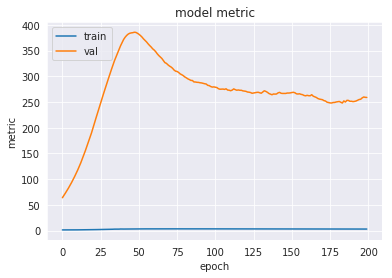

In [77]:
# summarize history for metric
path = './data/results/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.png'

adjustment_threshold_metric = 0#100
    
metric_df_adjusted = metric_df.copy(deep=True)
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True)
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model metric')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(path)
plt.show()


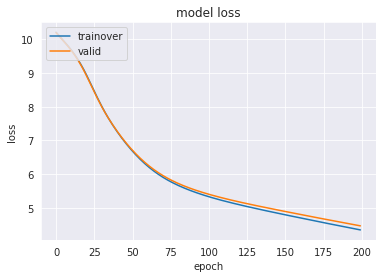

In [78]:
# summarize history for loss
path = './data/results/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/loss_' + str(data_size) +  '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_amax_' + str(a_max) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True)

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True)
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['trainover', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
